# Modelling a Perfectionist System: A Complete Walkthrough

A 35-year-old professional presents with chronic overwork and procrastination cycles. She describes a pattern: intense bursts of perfectionism followed by total shutdown. When her boss gives feedback, she feels a tightness in her chest and an overwhelming urge to either work harder or give up entirely.

We model her internal system with five Parts and walk through a complete therapeutic session using the `Session` facade.

## Clinical Context

This topology -- a Perfectionist-Procrastinator polarization protecting a Wounded Child -- is one of the most common configurations in IFS practice. The Perfectionist (Manager) drives relentless effort. The Procrastinator (Firefighter) shuts everything down when the pressure becomes unbearable. Both protect the same Exile: a young Part carrying the belief "I am not enough."

Additional complexity comes from the People-Pleaser (Manager, allied with the Perfectionist) and the Dissociator (Firefighter, a second emergency response). All four Protectors guard the same Wounded Child.

This notebook demonstrates the `Session` class -- a convenience wrapper that bundles the `ProtectionGraph`, `SelfSystem`, `TrailheadLog`, and `SixFsStateMachine` into a single coordinated unit.

In [1]:
from agentic_ifs import (
    Session,
    Manager,
    Firefighter,
    Exile,
    Burden,
    BurdenType,
    Edge,
    EdgeType,
    PolarizationEdge,
    BlendState,
    Trailhead,
    TrailheadType,
    FocusShift,
)

import networkx as nx
import matplotlib.pyplot as plt
import json

In [2]:
# Define the 5 Parts of the Perfectionist System

perfectionist = Manager(
    narrative="The Perfectionist -- must get everything right to avoid criticism",
    age=12,
    intent="Keep us safe from criticism by being perfect first",
    triggers=["criticism from authority", "perceived failure", "comparison to peers"],
    strategies=["perfectionism", "over-preparation", "self-criticism", "list-making"],
    rigidity=0.8,
)

people_pleaser = Manager(
    narrative="The People-Pleaser -- keeps everyone happy so they won't leave",
    age=9,
    intent="Maintain connection by meeting others' needs first",
    triggers=["disapproval", "conflict", "someone upset"],
    strategies=["agreeableness", "over-giving", "suppressing own needs"],
    rigidity=0.6,
)

procrastinator = Firefighter(
    narrative="The Procrastinator -- shuts down when pressure is too high",
    age=14,
    intent="Protect from overwhelm by stopping all effort",
    pain_threshold=0.6,
    extinguishing_behaviors=["avoidance", "distraction", "numbing", "doom-scrolling"],
)

dissociator = Firefighter(
    narrative="The Dissociator -- checks out when emotions get too intense",
    age=16,
    intent="Shield the system from unbearable feelings",
    pain_threshold=0.5,
    extinguishing_behaviors=["spacing out", "depersonalisation", "intellectual detachment"],
)

wounded_child = Exile(
    narrative="The Wounded Child -- carries shame from early school failure",
    age=7,
    intent="Hold the pain so the system can function",
    burden=Burden(
        burden_type=BurdenType.PERSONAL,
        origin="Age 7, public failure in school",
        content="I am not enough",
        emotional_charge=0.9,
    ),
    emotional_charge=0.7,
)

print("Parts created:")
for part in [perfectionist, people_pleaser, procrastinator, dissociator, wounded_child]:
    print(f"  [{part.part_type:12s}] {part.narrative[:55]}...")

Parts created:
  [manager     ] The Perfectionist -- must get everything right to avoid...
  [manager     ] The People-Pleaser -- keeps everyone happy so they won'...
  [firefighter ] The Procrastinator -- shuts down when pressure is too h...
  [firefighter ] The Dissociator -- checks out when emotions get too int...
  [exile       ] The Wounded Child -- carries shame from early school fa...


In [3]:
# Create the Session with typical starting self_energy (0.3)
session = Session(initial_self_energy=0.3)

# Add all 5 Parts
for part in [perfectionist, people_pleaser, procrastinator, dissociator, wounded_child]:
    session.add_part(part)

print(f"Session created with {len(session.graph.nodes)} Parts")
print(f"Initial self_energy: {session.self_system.self_energy}")

Session created with 5 Parts
Initial self_energy: 0.3


In [4]:
# Build the protection graph edges

# All 4 Protectors guard the Wounded Child
session.add_edge(Edge(source_id=perfectionist.id, target_id=wounded_child.id, edge_type=EdgeType.PROTECTS))
session.add_edge(Edge(source_id=people_pleaser.id, target_id=wounded_child.id, edge_type=EdgeType.PROTECTS))
session.add_edge(Edge(source_id=procrastinator.id, target_id=wounded_child.id, edge_type=EdgeType.PROTECTS))
session.add_edge(Edge(source_id=dissociator.id, target_id=wounded_child.id, edge_type=EdgeType.PROTECTS))

# Perfectionist and People-Pleaser are allied -- they cooperate
session.add_edge(Edge(source_id=perfectionist.id, target_id=people_pleaser.id, edge_type=EdgeType.ALLIED))

# Perfectionist and Procrastinator are polarized -- mutual escalation
session.add_polarization(PolarizationEdge(
    part_a_id=perfectionist.id,
    part_b_id=procrastinator.id,
    tension_level=0.7,
))

print(f"Edges:        {len(session.graph.edges)}")
print(f"Polarizations: {len(session.graph.polarization_edges)}")

# Blend the Perfectionist to model it being already active
# (the client arrives with the Perfectionist running -- that is why self_energy is low)
session.blend(BlendState(part_id=perfectionist.id, blending_percentage=0.7))
print(f"\nAfter blending Perfectionist at 70%:")
print(f"  self_energy: {session.self_system.self_energy}")
print(f"  is_self_led: {session.is_self_led}")

Edges:        5
Polarizations: 1

After blending Perfectionist at 70%:
  self_energy: 0.30000000000000004
  is_self_led: False


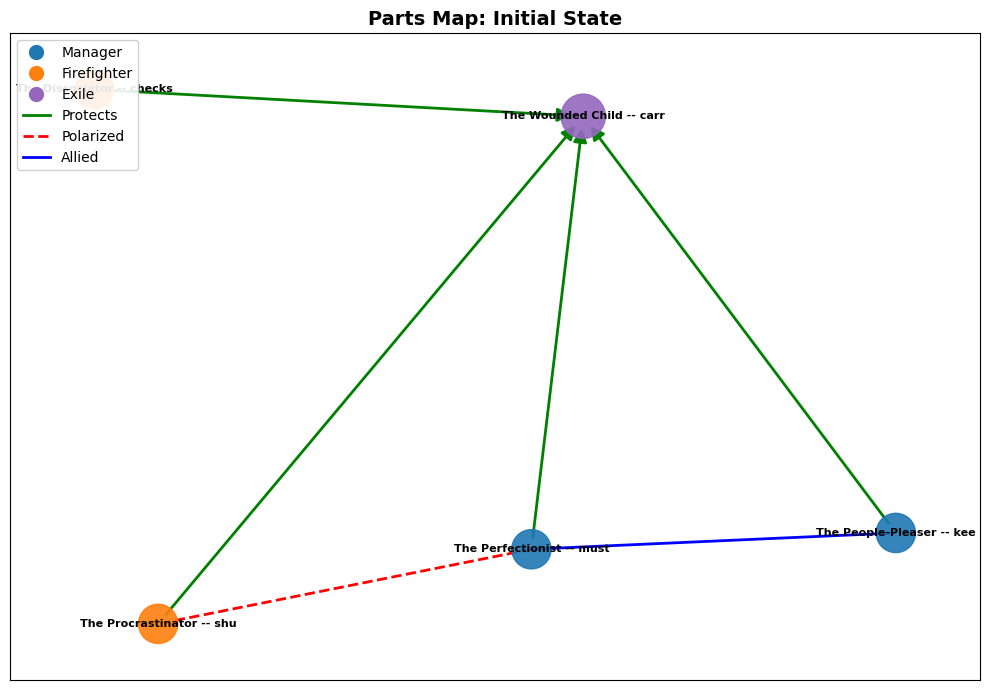

In [5]:
# Visualise the initial Parts Map

def draw_parts_map(graph, title="Parts Map"):
    """Render a ProtectionGraph as an inline matplotlib figure."""
    data = graph.to_json()

    G = nx.DiGraph()

    color_map = {"manager": "tab:blue", "firefighter": "tab:orange", "exile": "tab:purple"}

    node_colors = []
    node_sizes = []
    labels = {}

    for node in data["nodes"]:
        nid = node["id"]
        G.add_node(nid)
        node_colors.append(color_map.get(node["type"], "gray"))
        if node["type"] == "exile":
            node_sizes.append(600 + node.get("emotional_charge", 0.5) * 600)
        else:
            node_sizes.append(800)
        labels[nid] = node["label"][:25]

    protects_edges = []
    polarized_edges = []
    allied_edges = []

    for edge in data["edges"]:
        G.add_edge(edge["source"], edge["target"])
        if edge["type"] == "protects":
            protects_edges.append((edge["source"], edge["target"]))
        elif edge["type"] == "polarized":
            polarized_edges.append((edge["source"], edge["target"]))
        elif edge["type"] == "allied":
            allied_edges.append((edge["source"], edge["target"]))

    fig, ax = plt.subplots(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9, ax=ax)
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight="bold", ax=ax)

    if protects_edges:
        nx.draw_networkx_edges(G, pos, edgelist=protects_edges, edge_color="green",
                               style="solid", arrows=True, arrowsize=20, width=2, ax=ax)
    if polarized_edges:
        nx.draw_networkx_edges(G, pos, edgelist=polarized_edges, edge_color="red",
                               style="dashed", arrows=False, width=2, ax=ax)
    if allied_edges:
        nx.draw_networkx_edges(G, pos, edgelist=allied_edges, edge_color="blue",
                               style="solid", arrows=False, width=2, ax=ax)

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=12, label='Manager'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:orange', markersize=12, label='Firefighter'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:purple', markersize=12, label='Exile'),
        Line2D([0], [0], color='green', linewidth=2, label='Protects'),
        Line2D([0], [0], color='red', linewidth=2, linestyle='dashed', label='Polarized'),
        Line2D([0], [0], color='blue', linewidth=2, label='Allied'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', framealpha=0.9)

    ax.set_title(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


draw_parts_map(session.graph, title="Parts Map: Initial State")

In [6]:
# Check initial metrics
print("=== Initial System State ===")
print(f"Self-energy:         {session.self_system.self_energy}")
print(f"is_self_led:         {session.is_self_led}")
print(f"preservation_ratio:  {session.preservation_ratio:.3f}")
print(f"Active blends:       {len(session.self_system.active_blends)}")
for blend in session.self_system.active_blends:
    part = session.graph.nodes[blend.part_id]
    print(f"  - {part.narrative[:40]}... at {blend.blending_percentage:.0%}")

=== Initial System State ===
Self-energy:         0.30000000000000004
is_self_led:         False
preservation_ratio:  0.429
Active blends:       1
  - The Perfectionist -- must get everything... at 70%


## The Session Begins: U-Turn

The client says: "My boss gave me feedback on the quarterly report and I just froze. Then I went home and worked until 2am rewriting the whole thing."

The therapist guides the **U-Turn**: shifting attention from the external trigger (the boss's feedback) to the internal Part (the Perfectionist).

In [7]:
# Record the U-Turn
focus_shift = FocusShift(
    from_subject="Boss's feedback on the quarterly report",
    to_subject="The tightness in my chest -- my Perfectionist Part",
)
session.record_focus_shift(focus_shift)

print(f"U-Turn recorded:")
print(f"  From: {focus_shift.from_subject}")
print(f"  To:   {focus_shift.to_subject}")

# Create the trailhead
trailhead = Trailhead(
    trailhead_type=TrailheadType.SOMATIC,
    intensity=0.7,
    description="Tightness in chest and pressure behind the eyes when boss gives feedback",
    associated_part_id=perfectionist.id,
)
print(f"\nTrailhead: {trailhead.description}")
print(f"  Type:      {trailhead.trailhead_type.value}")
print(f"  Intensity: {trailhead.intensity}")

U-Turn recorded:
  From: Boss's feedback on the quarterly report
  To:   The tightness in my chest -- my Perfectionist Part

Trailhead: Tightness in chest and pressure behind the eyes when boss gives feedback
  Type:      somatic
  Intensity: 0.7


## Engaging the Perfectionist: The 6 Fs

We now walk through the 6 Fs with the Perfectionist. The system starts with the Perfectionist blended at 70%, so the Feel-Toward gate will fail -- requiring unblending before we can proceed.

In [8]:
# Step 1: Find
result = session.find(trailhead)
print(f"FIND: {result.notes}")
print(f"  next_step: {result.next_step}")

FIND: Trailhead: Tightness in chest and pressure behind the eyes when boss gives feedback (somatic)
  next_step: SixFsStep.FOCUS


In [9]:
# Step 2: Focus
result = session.focus(perfectionist.id)
print(f"FOCUS: Attention directed to {perfectionist.narrative[:30]}...")
print(f"  next_step: {result.next_step}")

FOCUS: Attention directed to The Perfectionist -- must get ...
  next_step: SixFsStep.FLESH_OUT


In [10]:
# Step 3: Flesh Out
result = session.flesh_out(perfectionist.id)
print(f"FLESH OUT:")
print(f"  {result.notes}")
print(f"  Triggers:   {perfectionist.triggers}")
print(f"  Strategies: {perfectionist.strategies}")
print(f"  Rigidity:   {perfectionist.rigidity}")
print(f"  next_step:  {result.next_step}")

FLESH OUT:
  Age: 12, Intent: Keep us safe from criticism by being perfect first
  Triggers:   ['criticism from authority', 'perceived failure', 'comparison to peers']
  Strategies: ['perfectionism', 'over-preparation', 'self-criticism', 'list-making']
  Rigidity:   0.8
  next_step:  SixFsStep.FEEL_TOWARD


In [11]:
# Step 4: Feel Toward -- THE GATE FAILS
#
# "How do you feel toward this Part?"
# Client: "Frustrated. I wish it would just stop."
# Therapist: "That frustration IS a Part. We need to ask it to step back."

result = session.feel_toward(perfectionist.id)

print(f"FEEL TOWARD:")
print(f"  self_energy:       {session.self_system.self_energy}")
print(f"  next_step:         {result.next_step}  <-- None = BLOCKED")
print(f"  unblend_required:  {result.unblend_required}")
print(f"  notes:             {result.notes}")
print()
print("When we ask 'how do you feel toward this Part?', the answer is")
print("frustration -- that frustration IS a Part. It has blended and must")
print("step back before Self can engage with the Perfectionist.")

FEEL TOWARD:
  self_energy:       0.30000000000000004
  next_step:         None  <-- None = BLOCKED
  unblend_required:  c5954b93-dafd-4063-80d1-9e1092400944
  notes:             Self-energy insufficient — another Part is blended

When we ask 'how do you feel toward this Part?', the answer is
frustration -- that frustration IS a Part. It has blended and must
step back before Self can engage with the Perfectionist.


In [12]:
# Unblend the Perfectionist and retry
print(f"Before unblend: self_energy = {session.self_system.self_energy}")

session.unblend(perfectionist.id)

print(f"After unblend:  self_energy = {session.self_system.self_energy}")
print(f"is_self_led:    {session.is_self_led}")
print()

# Retry feel_toward
result = session.feel_toward(perfectionist.id)
print(f"FEEL TOWARD (retry):")
print(f"  next_step:         {result.next_step}  <-- BEFRIEND = gate passes!")
print(f"  unblend_required:  {result.unblend_required}")
print(f"  notes:             {result.notes}")

Before unblend: self_energy = 0.30000000000000004
After unblend:  self_energy = 1.0
is_self_led:    True

FEEL TOWARD (retry):
  next_step:         SixFsStep.BEFRIEND  <-- BEFRIEND = gate passes!
  unblend_required:  None
  notes:             Self-energy sufficient — Self is present


In [13]:
# Step 5: Befriend
print(f"Trust BEFORE: {perfectionist.trust_level}")

result = session.befriend(perfectionist.id)

print(f"Trust AFTER:  {perfectionist.trust_level}")
print(f"\nBEFRIEND: {result.notes}")
print(f"  next_step: {result.next_step}")

Trust BEFORE: 0.5
Trust AFTER:  0.6

BEFRIEND: Trust updated to 0.60
  next_step: SixFsStep.FEAR


In [14]:
# Step 6: Fear
result = session.fear(perfectionist.id)

print(f"FEAR: {result.notes}")
print(f"  next_step: {result.next_step}  <-- None = 6 Fs complete")
print()
print("The Perfectionist's fear: 'If I stop being perfect, we will be")
print("criticised and rejected -- and the Wounded Child's shame will flood")
print("the system. I cannot let that happen.'")

FEAR: Protects 2 Part(s). Part intent: 'Keep us safe from criticism by being perfect first'
  next_step: None  <-- None = 6 Fs complete

The Perfectionist's fear: 'If I stop being perfect, we will be
criticised and rejected -- and the Wounded Child's shame will flood
the system. I cannot let that happen.'


In [15]:
# Print the session log as a formatted timeline
print("=== Session Timeline ===")
print()
print(f"{'#':<4} {'Time':<15} {'Event':<12} {'Description'}")
print("-" * 90)

for i, entry in enumerate(session.self_system.session_log, 1):
    ts = entry.timestamp.strftime("%H:%M:%S.%f")[:12]
    print(f"{i:<4} {ts:<15} {entry.event_type:<12} {entry.description}")

=== Session Timeline ===

#    Time            Event        Description
------------------------------------------------------------------------------------------
1    12:13:51.750    blend        Part blended at 70%
2    12:13:52.074    six_fs       FIND: Trailhead 'Tightness in chest and pressure behind the eyes when boss gives feedback' observed
3    12:13:52.088    six_fs       FOCUS: Attention directed to Part
4    12:13:52.102    six_fs       FLESH_OUT: Part aged 12, intent: 'Keep us safe from criticism by being perfect first'
5    12:13:52.112    six_fs       FEEL_TOWARD: Self-energy insufficient (0.30 <= 0.5) — unblend required
6    12:13:52.125    unblend      Part unblended
7    12:13:52.125    six_fs       FEEL_TOWARD: Self-energy sufficient (1.00 > 0.5)
8    12:13:52.140    six_fs       BEFRIEND: Trust updated to 0.60
9    12:13:52.154    six_fs       FEAR: Part protects 2 other Part(s)


Perfectionist trust level: 0.6 (was 0.5)



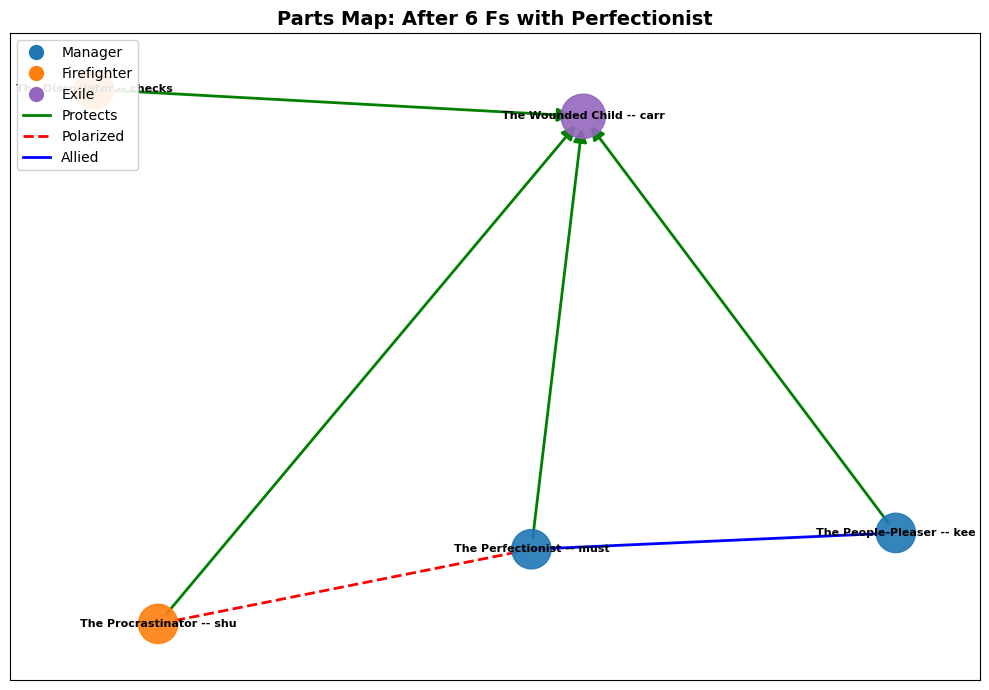

In [16]:
# Re-draw the Parts Map -- trust has increased for the Perfectionist
print(f"Perfectionist trust level: {perfectionist.trust_level} (was 0.5)")
print()
draw_parts_map(session.graph, title="Parts Map: After 6 Fs with Perfectionist")

In [17]:
# Export the Parts Map as JSON
parts_map_json = session.export_parts_map()
print(json.dumps(parts_map_json, indent=2))

{
  "nodes": [
    {
      "id": "c5954b93-dafd-4063-80d1-9e1092400944",
      "label": "The Perfectionist -- must get everything right to ",
      "type": "manager",
      "state": "idle",
      "trust_level": 0.6
    },
    {
      "id": "5e90ab83-0261-4226-9808-fa33caebb4c6",
      "label": "The People-Pleaser -- keeps everyone happy so they",
      "type": "manager",
      "state": "idle",
      "trust_level": 0.5
    },
    {
      "id": "2b8eb296-56e5-4c39-a405-ddaa8ff84973",
      "label": "The Procrastinator -- shuts down when pressure is ",
      "type": "firefighter",
      "state": "dormant",
      "trust_level": 0.5
    },
    {
      "id": "f9576e60-3933-441b-891b-c2e58f1daf28",
      "label": "The Dissociator -- checks out when emotions get to",
      "type": "firefighter",
      "state": "dormant",
      "trust_level": 0.5
    },
    {
      "id": "2a1878cc-f000-4b3a-84c0-17f732a8ea77",
      "label": "The Wounded Child -- carries shame from early scho",
      "type": "e

## Reflection

In real IFS therapy, the 6 Fs would be repeated across multiple sessions -- engaging each Protector, building trust, and eventually (in V2) accessing the Exile for unburdening work.

What we demonstrated:
- **5 Parts** in a realistic topology: two Managers (Perfectionist, People-Pleaser), two Firefighters (Procrastinator, Dissociator), and one Exile (Wounded Child)
- **Protection edges**: all four Protectors guard the Wounded Child
- **Polarization**: Perfectionist and Procrastinator locked in mutual escalation
- **Alliance**: Perfectionist and People-Pleaser cooperate
- **Blending mechanics**: the Perfectionist starts blended at 70%, dropping self_energy to 0.3
- **The Feel-Toward gate**: fails because the Perfectionist is blended, requiring unblending before proceeding
- **Trust building**: the Perfectionist's trust in Self increases from 0.5 to 0.6 through the Befriend step
- **Session logging**: every event is timestamped and recorded

V1 provides the **structures** for this work. V2 will add:
- Unburdening pipeline (Witnessing, Retrieval, Purging, Invitation)
- Legacy Burden lineage data structures
- 8C Self-energy vector breakdown (Curiosity, Calm, Clarity, Compassion, Confidence, Courage, Creativity, Connectedness)
- Direct Access mode
- LLM simulation of Part dialogue